In [2]:
#SET GLOBAL VARS AND IMPORTS

from draftbot_sim_adapted import *
from Experimentation_Utils import *
from Agents import *
import sqlite3
import pandas as pd
import numpy as np
import json
import os

import matplotlib.pyplot as plt

##GLOBAL VARS

draft_str='C:/Users/trist/OneDrive/Documents/draft_data_public.VOW.PremierDraft.csv'

#Have a couple versions of new/retooled bots to make sure the behavior makes sense over time
#Now all bots should auto-generate a unique name so you can differentiate these
agents = [Basic_Agent(),
Greedy_Agent(),
Arch_Reciever_Agent(),
Med_Agent(),
Dummy_Agent(),
Force_K_Agent(k_forced=5),
Force_K_Agent(k_forced=15),
Force_K_Agent(k_forced=30),
Arch_Pass_Agent(),
Hard_Agent(),
Hard_Agent(bias_function='log10'),
Hard_Agent(bias_function='ln')
]

def update_experiments(path:str):
    "Iterate through a folder of weights and automatically generate our experiment data"
    #for each item in our processed weights directory
    for it in os.listdir('weights_data/processed_weights'):

        #Iterate through our files
        string = 'weights_data/processed_weights' + '/' + it 
        simulation_generator(draft_str,string, agents, 4200, 11)

        #no return, this function works on the device

def display_draftwise_results(result_path,include_t3_data=False,n_picks=42):
    """Present results that show what % the bots match 
    human picks given the filename holding the picks"""

    #Read csv
    df = pd.read_csv(result_path)

    #Get rid of dummy index column
    df = df.iloc[:,1:]

    #If you also want to know about t3 data, you can set this flag to true
    if include_t3_data == False:
        
        #Remove all cols that include the str t3
        df = df.loc[:,~df.columns.str.contains('t3')]
    
    #Mean here is avg # of picks matched, so the rate is the avg/total picks
    results = df.mean()/n_picks
    results = results.sort_values(ascending=False)
    print(results)

def display_pickwise_results(performance_string, visualization='table'):
    """Present results that show % bots match human picks at the pick level. 
    That is, if there are 3 packs of 14 cards, then there are 42 picks at which
    the bots will have different accuracies. Each multiple of 14 will have an
    accuracy of 100% since you can only pick from one card at these points"""

    df = pd.read_csv(performance_string)

    df.rename(columns={'Unnamed: 0':'match_index'}, inplace=True)

    #only include cols that keep track of our match boolean values
    #also set all colnames to lowercase because some old files have diff capitilzation patterns
    df.columns = df.columns.str.lower()
    df = df.loc[:,df.columns.str.contains('match')]

    #Sub out the text from our input file (Python isn't reading the T/F as boolean by default)
    #df = df.replace({False: 0, True: 1})
    output_df = df.groupby('match_index').mean()

    #Print a df where we have 42 rows (1 per pick in a standard draft), where each bot has an accuracy %
    if visualization=='table':
        return output_df

    #If you also want a plot, add this logic in here
    else:
    
        df.groupby('match_index').mean().plot()

        #Move legend off to the side
        plt.legend(loc=(1.04,.35))

        #Show off the plot
        plt.show()


# REPORT SUMMARY: NEW WEIGHTING METRIC BUMPS ACCURACY 10 PERCENT POINTS TO MOVE US FORWARD FOR WEEK OF 4/1
By reading through this notebook, you will be able to see where our models sat across several different 
bots and metric weights. 

From the previous week the following bugs have been fixed:

a) Not landing 100% accuracy with only one card to pick from (Now we should get 100% accuracy barring an edge case)

b) Greedy and basic bots exclusively acting the same (they don't anymore, but some input data could lead to this behavior)

c) Numerous filename conventions in the weight generators/simulators have been standardized

d) Syntax/logic errors stemming from the fix outlined in a) have been resolved

e) Randombot actually chooses randomly (previously, this defaulted to the first card in the pack for some reason)

From the previous week the following new items have been created:

a) weights data for a "seen rate" (# times picked/ # times seen for a given card) and the GDWR (games where card is drawn win rate)

b) experiment outputs based on the items in a)

c) Output helper functions for pick level and draft level analysis

d) Last and not least, the hard bot has been introduced. Following the Ryan Saxe paper and introducing a few different ways to implement it,
we now have a bot with a dynamic bias term for pool weights (e.g the pool weights have more or less weight depending on the pick). I started
off with ln, log10, and linear functions to do this bias term, but am happy to try new implentations going forward. 

Key Findings:

a) With the introduction of new metrics, our best accuracy has shifted from the mid 30's (I believe 34.xx% was our best so far with IWD) to being around 44%. 

b) The basic bot is not always the best bot anymore (meaning the introduction of new weighting metrics); now our alternative strategies have meaning!

c) Use of the "seen_rate" is a better proxy for predicting/calculating picks than in-game data. A brief hypothesis as to why this makes sense is included below. 

Next Steps/Ideas:

a) Iterate on Hard Bot (add new functions to implement the bias term)

b) Consider iterating on pass/receiver agents to abstract to the color level (may be very difficult)

c) Try a few more metrics (Avg. draft position); note that avg. draft position isn't archetype specific, so a card has the same average draft position in all archetypes (so we'd need to consider this a bit more before proceeding.)

d) Turn up the sample size on this reports experiment (e.g. crank sample from 4200 to 42k or 420k) and see results

d) Collect sources we need to get consent/permissions from (e.g. 17lands potentially, citing Saxe paper)

e) Discuss potential analysis avenues to move this into a paper since our accuracy has jumped into the space that other papers have sat in.

f) Maybe run some experiments on traditional drafts from 17lands (maybe there are fundamentally different behaviors, but maybe this is beyond our scope)

Most sections that need explanation (such as the new weight metrics) have an intro. Most of the work done here is in the
experimentation utils and agents files, you can review changes there in the repository. Link here: https://github.com/ttew-bu/drafting-research
(If repository access isn't granted, just let me know and I'll hop right on it)

In [28]:
##DO NOT RUN THIS CELL WITHOUT UPDATING THE REPO AND ENSURING YOUR WEIGHTS ARE CURRENT/CORRECT
#update_experiments('weights_data/processed_weights')

# Assessing Individual Model Performance Across 1000 Sample Drafts for Different Weight Criteria
Below, you will see "seen rate" (# times picked / # times seen across the sample of drafts), "IWD" (Improvement when drawn), and "GP WR" (games played win rate when card in deck). The best performing metric is the "seen rate" criterion. This makes sense since it would be most correlated with the decision to put a card in your deck. The other proxies/metrics also depend on winning matches with the card in the deck or drawn, and no match is purely the function of one card; as a result, our results should be a bit noisier if we are using them for a drafting heuristic.

To set up the weights for each metric this rough process was applied: Scrape data from 17lands (win rate, pick rate etc.) fo each arch. If a card was seen/picked less than a given threshold (originally 5000 but this made performance worse so the number landed around 2000) and was non-mythic for a given archetype, then we would 0 out the weight for that card in the archetype. The only metric that did not have this transform applied was the "seen rate" since that would be agnostic of the volume of times the card was seen (e.g. 5/100 is the same as 50/1000 and both cards are relatively bad), and it turns out this actually performs well. 

Each section below will talk a bit more about the metric used and then show 4 printouts of how each of our agents performed across the same 1000 drafts with the only difference between the metric/preprocessing steps. "minmax" weights have the final weights scaled between 1-5 (5 is best, 1 is worst) before being plugged into the model for each arch (e.g. if there are 10 archs, each arch has 1 card with a weight of 5 unless there is a tie for best). If "color" is in the filename for the weights, then an additional preprocessing step of zeroing out non-arch weights (e.g. a blue black card has a nonzero weight only in blue or black archetypes) has been applied. You can ignore the 'Unnamed: 0' value in the output as that is taking the mean of the id column, which is meaningless. 

## Testing Accuracies Using the "seen rate" as a our weighting criterion
First, this is a derived field I calculated from the 17lands output, so you will not see this if you look for it on their website. The seen rate used here is the # times the card was seen in all of 17lands drafts/# times selected in an arch e.g. if a card appears in 1200 drafts, the denominator is 1200 and if it was an elite rare in the archetype, the numerator here could be 900 or some high #. That makes our resultant seen rate 75%. As you can see below, this metric sees as much as a 6 pick improvement in some models (e.g. from 12/42 to 18/42). It is worth noting that we do not "zero" out cards at any # of times seen here. Since every card has some sort of pick rate and the volume of times seen is not a predictor itself (a card seen 5/10 or 500/1000 times are the same), it is not apparent that we would need to 0 anything out here. Also given the performance hike, it also looks like we can get better predictions on data with less data manipulation. 

While this improves performance tremendously, there is a potential caveat here. 17Lands highights that sometimes, the top pick in a pack doesn't get registered. For example, we have some cards where # picked / # seen, which is impossible. This seems to be the result of the glitch, but it strangely works. In theory, cards that were selected 1st overall are good cards. So, even if their pick rate is above 100%, the fact that these rates are super high still gets the idea across to our bots that they are very good. Cards with low pick rates will still be worse. You can see below the effects of scaling these values between 1-5 and zeroing out those in other colors (note that we don't 0 anything out here because the cards are all seen hundreds of times)

One other note to highlight here is this is the first time we have found that the basic bot is not the best bot on every set of data we weigh. The arch receiver both performs slightly better when we apply a basic minmax scaler here (which is the most logical weighing process given that weighing non-arch cards at 0 is a bit extreme)


In [29]:
display_draftwise_results('results_data/VOM_weights_seen_rates_4200.csv')

t1_sum                               0.674521
force_k_agent_k_15_match             0.437162
basic_agent_match                    0.436917
hard_agent_21_linear_match           0.436917
hard_agent_21_log10_match            0.436917
hard_agent_21_ln_match               0.436917
force_k_agent_k_5_match              0.435935
force_k_agent_k_30_match             0.427099
Greedy Agent_turns_greedy_0_match    0.425626
arch_receiver_agent_match            0.424890
arch_pass_agent_match                0.422435
med_agent_archs_[0, 1, 2]_match      0.365979
dummy_agent_random_match             0.236377
dtype: float64


In [30]:
display_draftwise_results('results_data/VOM_weights_seen_rates_minmax_4200.csv')

t1_sum                               0.650957
force_k_agent_k_15_match             0.438144
force_k_agent_k_5_match              0.434462
arch_pass_agent_match                0.433481
arch_receiver_agent_match            0.433235
basic_agent_match                    0.432008
hard_agent_21_linear_match           0.432008
hard_agent_21_log10_match            0.432008
hard_agent_21_ln_match               0.432008
force_k_agent_k_30_match             0.424153
Greedy Agent_turns_greedy_0_match    0.419735
med_agent_archs_[0, 1, 2]_match      0.374325
dummy_agent_random_match             0.233677
dtype: float64


In [31]:
display_draftwise_results('results_data/VOM_weights_seen_rates_colors_4200.csv')

t1_sum                               0.654639
force_k_agent_k_15_match             0.417771
Greedy Agent_turns_greedy_0_match    0.417526
force_k_agent_k_5_match              0.416789
basic_agent_match                    0.416298
hard_agent_21_linear_match           0.416298
hard_agent_21_log10_match            0.416298
hard_agent_21_ln_match               0.416298
force_k_agent_k_30_match             0.416053
arch_receiver_agent_match            0.400835
arch_pass_agent_match                0.399116
med_agent_archs_[0, 1, 2]_match      0.335542
dummy_agent_random_match             0.234168
dtype: float64


In [7]:
display_draftwise_results('results_data/VOM_weights_seen_rates_minmax_colors_4200.csv')

t1_sum                               0.642857
basic_agent_match                    0.339715
hard_agent_21_linear_match           0.339715
hard_agent_21_log10_match            0.339715
hard_agent_21_ln_match               0.339715
arch_receiver_agent_match            0.335788
arch_pass_agent_match                0.330879
force_k_agent_k_15_match             0.325233
Greedy Agent_turns_greedy_0_match    0.319833
force_k_agent_k_30_match             0.315660
force_k_agent_k_5_match              0.311487
med_agent_archs_[0, 1, 2]_match      0.274669
dummy_agent_random_match             0.227786
dtype: float64


## Looking at Per-Pick Data for our Best Metric

Below are graphs and tables showing the per-pick data as we reviewed last week, but for these experiments using the seen rate. 

In [8]:
table = display_pickwise_results('performance_data/VOM_weights_seen_rates_4200_t1_performance.csv')
table

,basic_agent_match,greedy agent_turns_greedy_0_match,arch_receiver_agent_match,"med_agent_archs_[0, 1, 2]_match",dummy_agent_random_match,force_k_agent_k_5_match,force_k_agent_k_15_match,force_k_agent_k_30_match,arch_pass_agent_match,hard_agent_21_linear_match,hard_agent_21_log10_match,hard_agent_21_ln_match
match_index,,,,,,,,,,,,
0,0.670103,0.742268,0.670103,0.402062,0.072165,0.742268,0.742268,0.742268,0.670103,0.670103,0.670103,0.670103
1,0.505155,0.474227,0.536082,0.237113,0.082474,0.474227,0.474227,0.474227,0.463918,0.505155,0.505155,0.505155
2,0.422680,0.412371,0.298969,0.309278,0.072165,0.412371,0.412371,0.412371,0.329897,0.422680,0.422680,0.422680
3,0.381443,0.360825,0.371134,0.288660,0.092784,0.360825,0.360825,0.360825,0.381443,0.381443,0.381443,0.381443
4,0.360825,0.381443,0.319588,0.247423,0.082474,0.381443,0.381443,0.381443,0.329897,0.360825,0.360825,0.360825
5,0.422680,0.288660,0.381443,0.247423,0.123711,0.402062,0.288660,0.288660,0.371134,0.422680,0.422680,0.422680
6,0.340206,0.371134,0.309278,0.237113,0.144330,0.309278,0.371134,0.371134,0.298969,0.340206,0.340206,0.340206
7,0.350515,0.391753,0.402062,0.340206,0.134021,0.340206,0.391753,0.391753,0.391753,0.350515,0.350515,0.350515
8,0.340206,0.329897,0.319588,0.226804,0.154639,0.360825,0.329897,0.329897,0.309278,0.340206,0.340206,0.340206


In [9]:
table = display_pickwise_results('performance_data/VOM_weights_seen_rates_minmax_4200_t1_performance.csv')
table

,basic_agent_match,greedy agent_turns_greedy_0_match,arch_receiver_agent_match,"med_agent_archs_[0, 1, 2]_match",dummy_agent_random_match,force_k_agent_k_5_match,force_k_agent_k_15_match,force_k_agent_k_30_match,arch_pass_agent_match,hard_agent_21_linear_match,hard_agent_21_log10_match,hard_agent_21_ln_match
match_index,,,,,,,,,,,,
0,0.639175,0.701031,0.639175,0.453608,0.072165,0.701031,0.701031,0.701031,0.639175,0.639175,0.639175,0.639175
1,0.505155,0.453608,0.515464,0.237113,0.061856,0.453608,0.453608,0.453608,0.494845,0.505155,0.505155,0.505155
2,0.412371,0.453608,0.402062,0.268041,0.082474,0.453608,0.453608,0.453608,0.402062,0.412371,0.412371,0.412371
3,0.432990,0.381443,0.432990,0.309278,0.020619,0.381443,0.381443,0.381443,0.432990,0.432990,0.432990,0.432990
4,0.319588,0.298969,0.309278,0.268041,0.144330,0.298969,0.298969,0.298969,0.309278,0.319588,0.319588,0.319588
5,0.391753,0.309278,0.402062,0.237113,0.123711,0.422680,0.309278,0.309278,0.402062,0.391753,0.391753,0.391753
6,0.309278,0.329897,0.319588,0.257732,0.144330,0.268041,0.329897,0.329897,0.319588,0.309278,0.309278,0.309278
7,0.340206,0.350515,0.329897,0.319588,0.175258,0.309278,0.350515,0.350515,0.340206,0.340206,0.340206,0.340206
8,0.268041,0.298969,0.268041,0.298969,0.154639,0.288660,0.298969,0.298969,0.268041,0.268041,0.268041,0.268041


In [10]:
table = display_pickwise_results('performance_data/VOM_weights_seen_rates_colors_4200_t1_performance.csv')
table

,basic_agent_match,greedy agent_turns_greedy_0_match,arch_receiver_agent_match,"med_agent_archs_[0, 1, 2]_match",dummy_agent_random_match,force_k_agent_k_5_match,force_k_agent_k_15_match,force_k_agent_k_30_match,arch_pass_agent_match,hard_agent_21_linear_match,hard_agent_21_log10_match,hard_agent_21_ln_match
match_index,,,,,,,,,,,,
0,0.639175,0.701031,0.639175,0.381443,0.123711,0.701031,0.701031,0.701031,0.639175,0.639175,0.639175,0.639175
1,0.463918,0.463918,0.443299,0.237113,0.092784,0.463918,0.463918,0.463918,0.391753,0.463918,0.463918,0.463918
2,0.360825,0.360825,0.329897,0.309278,0.061856,0.360825,0.360825,0.360825,0.298969,0.360825,0.360825,0.360825
3,0.381443,0.319588,0.350515,0.288660,0.072165,0.319588,0.319588,0.319588,0.391753,0.381443,0.381443,0.381443
4,0.298969,0.298969,0.247423,0.278351,0.164948,0.298969,0.298969,0.298969,0.247423,0.298969,0.298969,0.298969
5,0.350515,0.288660,0.288660,0.226804,0.113402,0.319588,0.288660,0.288660,0.298969,0.350515,0.350515,0.350515
6,0.309278,0.350515,0.350515,0.257732,0.154639,0.309278,0.350515,0.350515,0.319588,0.309278,0.309278,0.309278
7,0.329897,0.360825,0.412371,0.350515,0.206186,0.350515,0.360825,0.360825,0.412371,0.329897,0.329897,0.329897
8,0.371134,0.360825,0.329897,0.247423,0.216495,0.360825,0.360825,0.360825,0.329897,0.371134,0.371134,0.371134


In [11]:
table = display_pickwise_results('performance_data/VOM_weights_seen_rates_minmax_colors_4200_t1_performance.csv')
table

,basic_agent_match,greedy agent_turns_greedy_0_match,arch_receiver_agent_match,"med_agent_archs_[0, 1, 2]_match",dummy_agent_random_match,force_k_agent_k_5_match,force_k_agent_k_15_match,force_k_agent_k_30_match,arch_pass_agent_match,hard_agent_21_linear_match,hard_agent_21_log10_match,hard_agent_21_ln_match
match_index,,,,,,,,,,,,
0,0.381443,0.247423,0.381443,0.154639,0.061856,0.247423,0.247423,0.247423,0.381443,0.381443,0.381443,0.381443
1,0.309278,0.360825,0.298969,0.134021,0.051546,0.360825,0.360825,0.360825,0.257732,0.309278,0.309278,0.309278
2,0.278351,0.144330,0.216495,0.185567,0.041237,0.144330,0.144330,0.144330,0.195876,0.278351,0.278351,0.278351
3,0.298969,0.175258,0.278351,0.195876,0.061856,0.175258,0.175258,0.175258,0.298969,0.298969,0.298969,0.298969
4,0.206186,0.206186,0.216495,0.206186,0.123711,0.206186,0.206186,0.206186,0.206186,0.206186,0.206186,0.206186
5,0.329897,0.247423,0.278351,0.175258,0.082474,0.216495,0.247423,0.247423,0.268041,0.329897,0.329897,0.329897
6,0.206186,0.298969,0.216495,0.134021,0.113402,0.247423,0.298969,0.298969,0.206186,0.206186,0.206186,0.206186
7,0.257732,0.247423,0.319588,0.237113,0.144330,0.288660,0.247423,0.247423,0.319588,0.257732,0.257732,0.257732
8,0.247423,0.329897,0.257732,0.237113,0.247423,0.268041,0.329897,0.329897,0.257732,0.247423,0.247423,0.247423


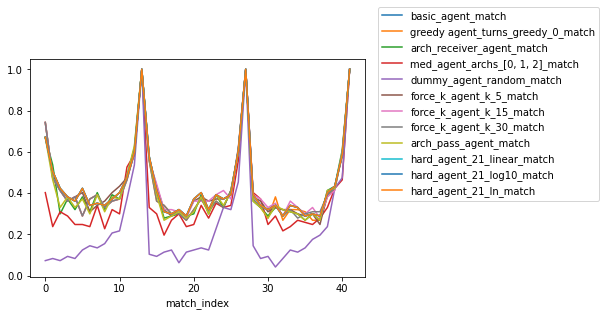

In [12]:
display_pickwise_results('performance_data/VOM_weights_seen_rates_4200_t1_performance.csv',visualization='plot')

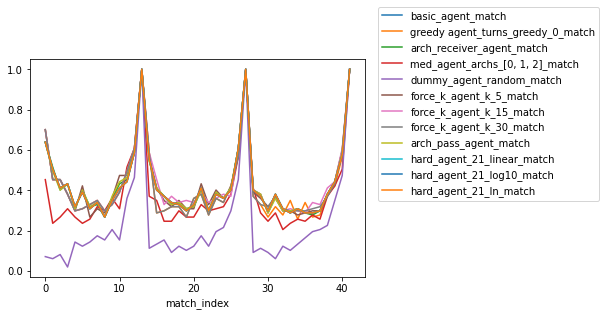

In [13]:
display_pickwise_results('performance_data/VOM_weights_seen_rates_minmax_4200_t1_performance.csv',visualization='plot')

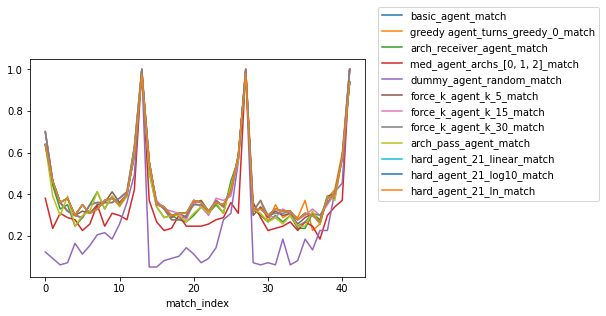

In [14]:
display_pickwise_results('performance_data/VOM_weights_seen_rates_colors_4200_t1_performance.csv',visualization='plot')

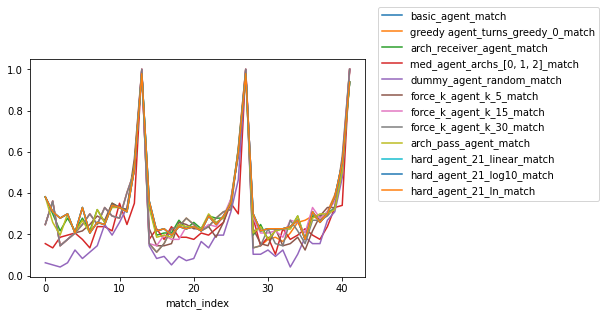

In [15]:
display_pickwise_results('performance_data/VOM_weights_seen_rates_minmax_colors_4200_t1_performance.csv',visualization='plot')

## Testing Accuracies Using the "GD WR " as a our weighting criterion
This field comes from the Games Drawn Win Rate column in the data - I explored this because it seemed like another reasonable metric to look at. It came with a similar challenge to the IWD in that we did not have a value in every archetype. If there were less than 2000 plays, then a card was assigned a weight of 0 for an arch. If a card had above 0 it was either given the global (e.g. all archetypes) va;ue for the card or the archetype specific value when possible. As a result, this follows the new weighing criteria discussed over email. 

I applied additional transforms (e.g. min-max 1-5 or zeroing out noncolor values) to the individual datasets after performing the steps above. There is not too much notable about the results of these experiments. They're about as accurate as the IWD, though zeroing out for color leads to performance over 36%. 

Like I mention in other parts of this report, this metric may not be the best reflection of what drives pick behavior because it is unlikely that drawing a single card or not is a major indicator of card value. For example, a card could be drawn late in the game when you're already losing even if it is good, or it could be drawn too early and the player can't use it until it is too late. In short, our results make sense because this isn't the closest proxy to card value in drafting, though it may speak to card value in deck construction. 

In [16]:
display_draftwise_results('results_data/VOM_Weights_GPWR_4200.csv')

t1_sum                               0.647275
Greedy Agent_turns_greedy_0_match    0.342906
force_k_agent_k_30_match             0.341433
force_k_agent_k_15_match             0.332351
force_k_agent_k_5_match              0.330633
basic_agent_match                    0.325970
hard_agent_21_linear_match           0.325970
hard_agent_21_log10_match            0.325970
hard_agent_21_ln_match               0.325970
arch_pass_agent_match                0.292587
arch_receiver_agent_match            0.291605
med_agent_archs_[0, 1, 2]_match      0.278351
dummy_agent_random_match             0.241041
dtype: float64


In [17]:
display_draftwise_results('results_data/VOM_Weights_GPWR_minmax_4200.csv')

t1_sum                               0.611438
basic_agent_match                    0.308787
hard_agent_21_linear_match           0.308787
hard_agent_21_log10_match            0.308787
hard_agent_21_ln_match               0.308787
force_k_agent_k_5_match              0.295042
arch_receiver_agent_match            0.288414
arch_pass_agent_match                0.285469
med_agent_archs_[0, 1, 2]_match      0.275896
force_k_agent_k_15_match             0.272214
force_k_agent_k_30_match             0.264605
Greedy Agent_turns_greedy_0_match    0.261659
dummy_agent_random_match             0.221895
dtype: float64


In [18]:
display_draftwise_results('results_data/VOM_Weights_GPWR_colors_4200.csv')

t1_sum                               0.655130
basic_agent_match                    0.363770
hard_agent_21_linear_match           0.363770
hard_agent_21_log10_match            0.363770
hard_agent_21_ln_match               0.363770
force_k_agent_k_30_match             0.351497
Greedy Agent_turns_greedy_0_match    0.349534
force_k_agent_k_15_match             0.339470
force_k_agent_k_5_match              0.338243
arch_receiver_agent_match            0.310260
arch_pass_agent_match                0.306824
med_agent_archs_[0, 1, 2]_match      0.271232
dummy_agent_random_match             0.232941
dtype: float64


In [19]:
display_draftwise_results('results_data/VOM_Weights_GPWR_minmax_colors_4200.csv')

t1_sum                               0.661021
basic_agent_match                    0.332597
hard_agent_21_linear_match           0.332597
hard_agent_21_log10_match            0.332597
hard_agent_21_ln_match               0.332597
force_k_agent_k_5_match              0.302160
arch_receiver_agent_match            0.290378
arch_pass_agent_match                0.287678
force_k_agent_k_15_match             0.276632
force_k_agent_k_30_match             0.268287
med_agent_archs_[0, 1, 2]_match      0.260187
Greedy Agent_turns_greedy_0_match    0.256996
dummy_agent_random_match             0.235395
dtype: float64


## Re-Testing Accuracies Using the "IWD" as a our weighting criterion
The IWD here is the 'Improvement when drawn' sourced from 17lands. This suggests that the odds of success in a match go up (or down) by drawing the card and serves as a proxy for being good. The process to generate these weights is to take raw 17lands data overall/in archetypes, zero out IWDs for non-mythics with fewer than 2500 selections, and then apply the various transformations (scale 1-5 and additionally 0 out non-color cards) to our various sets. "minmax" in the filename means we scaled 1-5, "colors" means that we zeroed out noncolor cards (e.g. all white cards have a weight of zero in a black blue deck). Generally, the minmax function improved performance and adding an additional layer of filtering on color was detrimental. 

This was our initial measuring stick and frankly, the performance (meaning how well we match human picks) is worse than the other metrics measured here. This is to be expected because not every card may be drawn in every match and so a card being drawn and improving the odds of winning may be a bit too complex of a proxy for the odds somebody picks it. By adding this condition of being drawn as opposed to simply being in the deck, we may be adding in additional noise that makes our bots perform worse.

Also, note that there are two IWD sections in this notebook. The "new" method employs the weighing process we talked about in the email (0 out if seen below 5000). Neither of these are our best metrics, so there's not too much to report here. 

OLD IWD SECTION BELOW:

In [20]:
display_draftwise_results('results_data/VOM_Weights_IWD_4200.csv')

t1_sum                               0.583947
Greedy Agent_turns_greedy_0_match    0.333333
force_k_agent_k_30_match             0.305596
force_k_agent_k_15_match             0.263623
force_k_agent_k_5_match              0.243986
dummy_agent_random_match             0.222877
med_agent_archs_[0, 1, 2]_match      0.201522
basic_agent_match                    0.119293
hard_agent_21_linear_match           0.119293
hard_agent_21_log10_match            0.119293
hard_agent_21_ln_match               0.119293
arch_receiver_agent_match            0.118066
arch_pass_agent_match                0.118066
dtype: float64


In [21]:
display_draftwise_results('results_data/VOM_Weights_IWD_colors_4200.csv')

t1_sum                               0.605547
Greedy Agent_turns_greedy_0_match    0.328424
force_k_agent_k_30_match             0.320324
force_k_agent_k_15_match             0.311733
force_k_agent_k_5_match              0.294305
med_agent_archs_[0, 1, 2]_match      0.267305
basic_agent_match                    0.261659
hard_agent_21_linear_match           0.261659
hard_agent_21_log10_match            0.261659
hard_agent_21_ln_match               0.261659
arch_receiver_agent_match            0.237604
arch_pass_agent_match                0.236132
dummy_agent_random_match             0.225577
dtype: float64


In [22]:
display_draftwise_results('results_data/VOM_Weights_IWD_minmax_4200.csv')

t1_sum                               0.548601
med_agent_archs_[0, 1, 2]_match      0.292833
arch_pass_agent_match                0.288660
arch_receiver_agent_match            0.288169
basic_agent_match                    0.286942
hard_agent_21_linear_match           0.286942
hard_agent_21_log10_match            0.286942
hard_agent_21_ln_match               0.286942
force_k_agent_k_5_match              0.275160
force_k_agent_k_15_match             0.274669
Greedy Agent_turns_greedy_0_match    0.273687
force_k_agent_k_30_match             0.266814
dummy_agent_random_match             0.237604
dtype: float64


In [23]:
display_draftwise_results('results_data/VOM_Weights_IWD_minmax_colors_4200.csv')

t1_sum                               0.618311
basic_agent_match                    0.290869
hard_agent_21_linear_match           0.290869
hard_agent_21_log10_match            0.290869
hard_agent_21_ln_match               0.290869
arch_receiver_agent_match            0.286451
arch_pass_agent_match                0.283505
force_k_agent_k_15_match             0.271232
Greedy Agent_turns_greedy_0_match    0.264850
force_k_agent_k_30_match             0.255277
med_agent_archs_[0, 1, 2]_match      0.254541
force_k_agent_k_5_match              0.251841
dummy_agent_random_match             0.227050
dtype: float64


NEW IWD SECTION BELOW:

In [24]:
display_draftwise_results('results_data/VOM_Weights_IWD_newmethod_4200.csv')

t1_sum                               0.595974
Greedy Agent_turns_greedy_0_match    0.321306
force_k_agent_k_30_match             0.303387
force_k_agent_k_15_match             0.263868
force_k_agent_k_5_match              0.251350
dummy_agent_random_match             0.229995
med_agent_archs_[0, 1, 2]_match      0.195876
basic_agent_match                    0.108738
hard_agent_21_linear_match           0.108738
hard_agent_21_log10_match            0.108738
hard_agent_21_ln_match               0.108738
arch_pass_agent_match                0.108247
arch_receiver_agent_match            0.107266
dtype: float64


In [25]:
display_draftwise_results('results_data/VOM_Weights_IWD_newmethod_minmax_4200.csv')

t1_sum                               0.554001
med_agent_archs_[0, 1, 2]_match      0.294305
force_k_agent_k_5_match              0.292833
Greedy Agent_turns_greedy_0_match    0.291851
force_k_agent_k_30_match             0.290869
arch_receiver_agent_match            0.289642
arch_pass_agent_match                0.289642
basic_agent_match                    0.285469
hard_agent_21_linear_match           0.285469
hard_agent_21_log10_match            0.285469
hard_agent_21_ln_match               0.285469
force_k_agent_k_15_match             0.284242
dummy_agent_random_match             0.237113
dtype: float64


In [26]:
display_draftwise_results('results_data/VOM_Weights_IWD_newmethod_colors_4200.csv')

t1_sum                               0.625675
Greedy Agent_turns_greedy_0_match    0.325724
force_k_agent_k_30_match             0.313942
force_k_agent_k_15_match             0.309278
force_k_agent_k_5_match              0.296760
med_agent_archs_[0, 1, 2]_match      0.265341
hard_agent_21_linear_match           0.263623
hard_agent_21_log10_match            0.263623
hard_agent_21_ln_match               0.263623
basic_agent_match                    0.263378
dummy_agent_random_match             0.233186
arch_receiver_agent_match            0.225331
arch_pass_agent_match                0.225086
dtype: float64


In [27]:
display_draftwise_results('results_data/VOM_Weights_IWD_newmethod_minmax_colors_4200.csv')

t1_sum                               0.645557
basic_agent_match                    0.322779
hard_agent_21_linear_match           0.322779
hard_agent_21_log10_match            0.322779
hard_agent_21_ln_match               0.322779
arch_receiver_agent_match            0.312715
arch_pass_agent_match                0.307069
Greedy Agent_turns_greedy_0_match    0.296514
force_k_agent_k_5_match              0.291114
force_k_agent_k_30_match             0.291114
force_k_agent_k_15_match             0.282278
med_agent_archs_[0, 1, 2]_match      0.261414
dummy_agent_random_match             0.233922
dtype: float64
